<a href="https://colab.research.google.com/github/shreyasrinarasi/finalyearproject/blob/master/realcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import datetime

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
df = pd.read_csv("/content/drive/My Drive/FinalYearProject/realdata.csv")
df.head()

,Voltage,Current,Power,Temperature,year,hour,dayofyear,month,minute
0,227,111,68,21,2019,6,14,1,59
1,226,146,84,21,2019,7,14,1,4
2,226,161,105,22,2019,7,14,1,9
3,225,210,135,22,2019,7,14,1,14
4,228,256,166,23,2019,7,14,1,19


In [75]:
df.values.shape

(66099, 9)

In [0]:
shift_days = 1
shift_steps = shift_days * 142 

In [0]:
target_names = ['Power']

In [0]:
df_targets = df[target_names].shift(-shift_steps)

In [0]:
x_data = df.values[0:-shift_steps]

In [0]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 9)


In [0]:
y_data = df_targets.values[:-shift_steps]

In [0]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 1)


In [0]:
num_data = len(x_data)
num_data

25970

In [0]:
train_split = 0.8

In [0]:
num_train = int(train_split * num_data)
num_train

20776

In [0]:
num_test = num_data - num_train
num_test

5194

In [0]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

25970

In [0]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

25970

In [0]:
num_x_signals = x_data.shape[1]
num_x_signals

9

In [0]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [0]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0
Max: 2019


In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(20776, 9)
(20776, 1)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 32

In [0]:
sequence_length = 142 * 7 * 8
sequence_length

7952

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
print(x_batch.shape)
print(y_batch.shape)

(32, 7952, 9)
(32, 7952, 1)


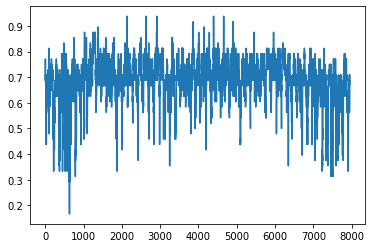

In [0]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

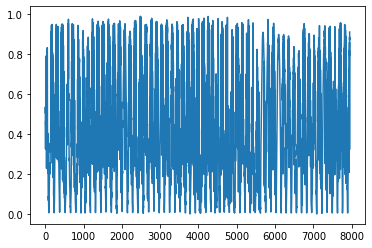

In [0]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

In [0]:
model.add(Dense(units=512,
               input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 0

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 512)         5120      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '/content/drive/My Drive/FinalYearProject/checkpoints/23_checkpoint_new1.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [0]:
%%time
model.fit(x=generator,
          epochs=1,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

142/142 [==============================] - ETA: 0s - loss: 0.0489
Epoch 00001: val_loss improved from inf to 0.06352, saving model to /content/drive/My Drive/FinalYearProject/checkpoints/23_checkpoint_new1.keras
142/142 [==============================] - 5s 38ms/step - loss: 0.0489 - val_loss: 0.0635 - lr: 0.0010
CPU times: user 6.74 s, sys: 517 ms, total: 7.26 s
Wall time: 5.94 s


In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0635


In [0]:
print("loss (test-set):", result)

loss (test-set): 0.06352140009403229


In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    realpo=0
    for i in range(start_idx,end_idx):
      realpo+=y_true[i]

    print("Real Power Output:", realpo)
  
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    

    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    poweroutput=0

    for i in range (start_idx, end_idx):
      poweroutput+=y_pred_rescaled[i]
    
    print("Predicted Power Output:", poweroutput)

    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

Real Power Output: [41321.]
Predicted Power Output: [43546.953]


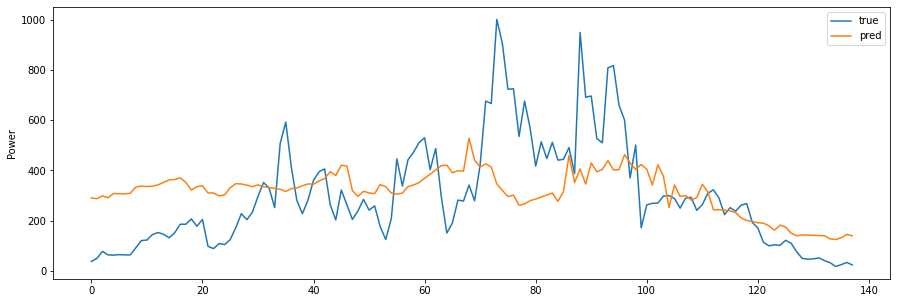

In [0]:
plot_comparison(start_idx=0, length=138, train=True)

Real Power Output: [65662.]
Predicted Power Output: [49784.504]


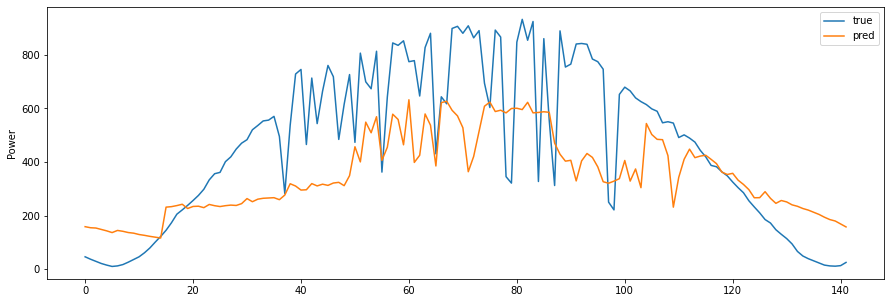

In [0]:
plot_comparison(start_idx=0, length=142, train=False)